In [317]:
import numpy as np
import pickle
import random

In [850]:
class BlackJackSolution:

    def __init__(self, lr=0.1, exp_rate=0.3, num_decks=6):
        
        # Create two dictionaries (one to hold Q values, one to hold win/total games)
        self.player_Q_Values = {}  # [(player_value, show_card, usable_ace)][action]: Qvalue
        self.stateActionOutcome = {} # [(player_value, show_card, usable_ace)][action]: [win,totalgames]
        
        # initialize Q values | (2-21) x (1-10) x (True, False) x (0,1,2,3) x (10,50,100) creates 4800
        # combinations for Q values
        
        # i loop for player hand total
        for i in range(2, 22):
            # j loop for dealer show card
            for j in range(1, 11):
                # k loop for if player has usable ace
                for k in [True, False]:
                    
                    # initialize our win/total game values in dictionary
                    self.stateActionOutcome[(i,j,k)] = {0:[0,0],1:[0,0],2:[0,0],3:[0,0]}
                    
                    for bet in [10,50,100]:
                        
                        # initialize a dictionary for each combination of states to hold action:Qvalue
                        self.player_Q_Values[(i, j, k, bet)] = {}
                        
                        # Loop through actions (0: Stay, 1: Hit, 2: Double Down, 3: Split)
                        for a in [0, 1, 2, 3]:
               
                            # Below, we initialize the model with some very primitive rules
            
                            # If the player has a 21, then we want a choice of stay (0) to have a 
                            # very high Q value  
                            if (i == 21) and (a == 0):
                                self.player_Q_Values[(i, j, k, bet)][a] = 99999999
                                
                            # If the player has less than 12, then staying is very dumb 
                            # so we set the Q value to a very negative number
                            elif (i < 12) and (a == 0):
                                self.player_Q_Values[(i, j, k, bet)][a] = -99999999
                                
                            # If you have two aces, always split (3)
                            elif (i == 2) and (a == 3):
                                self.player_Q_Values[(i, j, k, bet)][a] = 99999999
                            
                            # Otherwise, set the Q value to 0
                            else:
                                self.player_Q_Values[(i, j, k, bet)][a] = 0

        # Create attributes to keep track of various states, actions, etc.
        self.player_state_action = []
        self.state = (0, 0, False, 10)  # initial state
        self.actions = [1, 0, 2, 3]
        self.end = False # Used to end game
        self.lr = lr
        self.exp_rate = exp_rate
        self.num_decks = num_decks
        self.testStack = []
        
        # Action count is used to keep track of how many actions have been performed in a game
        self.actionCount = 0
        self.bet = 0
        
        # Initial thought: Have it be 3 elements (state on which split occurred, states for hand 1,
        # & states for hand 2)
        
        # splitStates is a special attribute to keep track of important state/action pairs during
        # a split. The first position will hold the state/action pair when a split is chosen.
        # The second and third positions will hold all state/action pairs to be rewarded/punished
        # in the first and second hands, respectively.
        self.splitStates = [0,[],[]] 
        
        # Split potential is used to keep track of if the dealt cards makes it possible to split
        self.split_potential = 0
        
        # Split outcome is used to tally up the outcomes from both hands (to reward/punish original
        # decision to split)
        self.splitOutcome = 0
        
        # Split final values is used to store the final player value of each hand in a split
        self.splitFinalValues = [0,0]
        
        # Added attribute to keep track of how well the model is learning
        self.gameTrack = []
        
        # Dict with faces
        self.f_dict = {'A': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6,
                 '7': 7, '8': 8, '9': 9, '10': 10, 'J': 10, 'Q': 10,
                 'K': 10}
    
    # Create stack
    def makeStack(self):
        
        # Create empty stack
        test_stack = []
        
        # Define new list with faces
        f_list = ['A','2','3','4','5','6','7','8','9','10','J','Q','K']
        
        # Extend empty stack by 4*num_decks*(list of cards)
        for i in range(self.num_decks):
            for j in range(4):
                test_stack.extend(f_list)
        
        # Shuffle the stack
        random.shuffle(test_stack)
        
        # Set the new stack
        self.testStack = test_stack
        
    # Deal single card
    def giveCard(self):
        
        # When stack falls below 52 cards, make a new stack
        if (len(self.testStack) < 52):
        
            self.makeStack()
            
        # Remove the first card from the stack and set it to card to deal
        cardToDeal = self.testStack.pop(0)
        
        return cardToDeal
    

    def dealerPolicy(self, current_value, usable_ace, is_end):
        
        if current_value > 21:
            
            # If dealer has a usable ace, convert it from an 11 to a 1 (subtract 10)
            # Otherwise, game is over, dealer busts
            if usable_ace:
                current_value -= 10
                usable_ace = False
            else:
                return current_value, usable_ace, True
            
        # Dealer stays on 17 or greater
        # Otherwise, deal a new card
        if current_value >= 17:
            return current_value, usable_ace, True
        else:
            card = self.giveCard()
            card_value = self.f_dict[card]
            
            # If card is an ace, check current_value and decide if we can convert
            # it to 11 or have to keep it as 1
            if card_value == 1:
                if current_value <= 10:
                    return current_value + 11, True, False
                return current_value + 1, usable_ace, False
            else:
                return current_value + card_value, usable_ace, False
    
    # Method for action to be chosen by player.
    # curRound and trainRound are used to keep track of what percentage of games
    # we've iterated through. This is used to adjust the exploration rate during sim.
    
    def chooseAction(self,curRound=0,trainRound=1000):
        
        # Player's current hand value is the first element of self.state
        current_value = self.state[0]

        # Whether to 'explore' or follow policy -- current code gradually shifts towards policy following
        # as more rounds are completed
        
        # Note that even the exploration phase has some simple rules built in, such as never staying
        # below 12, always splitting with two aces, etc. This is to avoid exploring obviously bad
        # strategies.
        
        # ********* Don't forget to switch back!!! **********
        #if (np.random.uniform(0, 1) <= self.exp_rate):
        if (np.random.uniform(0, 1) <= self.exp_rate*(1 - curRound/trainRound)):
            
            # 1) Obviously if current_value = 21, stay (0)
            # 2) If current_value < 12, exclude staying (0)
            # 3) If this is a second or later action, exclude double downs (2) and splits (3)
            if (current_value == 21):
                action = 0
                
            # If current hand value is greater than 11...
            elif (current_value > 11):
                
                # Allow all actions if it's first action and splits available
                if (self.actionCount == 0) and (self.split_potential == 1):
                    action = np.random.choice(self.actions)
                    
                # Exclude splits (3) if self.split_potential = 0
                elif (self.actionCount == 0):
                    action = np.random.choice(self.actions[0:3])
                    
                # Exclude splits and double downs if it's after first action
                else:
                    action = np.random.choice(self.actions[0:2])
                    
            # If the hand value is 2, then it's two aces --> split
            elif (current_value == 2):
                action = 3
                
            # Else, the hand value is less than 12 but not 2
            # Never stay!
            else:
                
                # If split potential is 1 and it's first action,
                # we can hit, double, split. If it's not first
                # action, we can only hit.
                if (self.split_potential == 1):
                    if (self.actionCount == 0):
                        action = np.random.choice([1,2,3])
                    else:
                        action = 1
                        
                # If it's first action with no split potential,
                # we can hit or double. Otherwise, we can only
                # hit.
                else:
                    if (self.actionCount == 0):
                        action = np.random.choice([1,2])
                    else:
                        action = 1
        
        # If we don't 'explore,' then we're following Q value policy
        else:
            
            # Use our basic rules to set an action if we can
            if current_value == 21:
                action = 0
            elif current_value == 2:
                action = 3
                
            # Otherwise we go through checking our Q scores
            else:
                # Initialize a 'v' variable to compare against first Q value and set a default
                # action of staying
                v = -9999999
                action = 0
                
                # Check each action's Q value for that state -- if it's higher than previous Q value,
                # make this the new chosen action.

                # Note that we skip checking some actions, as they cannot be performed with
                # certain states
                for a in self.player_Q_Values[self.state]:

                    # If we've already made a prior action, we can't double down or split
                    # Therefore, skip these actions in the loop
                    if ((self.actionCount > 0) and (a > 1)):        
                        continue

                    # If there's no split potential, skip splitting as a choice
                    if ((self.split_potential == 0) and (a == 3)):
                        continue

                    # if the above two conditions aren't true, all actions are on the table
                    if self.player_Q_Values[self.state][a] > v:
                        action = a
                        v = self.player_Q_Values[self.state][a]
        
        
        # Increment our action count
        self.actionCount += 1
        
        return action

    # Method to create the next state, based on the chosen action, and check if game
    # will continue
    def playerNxtState(self, action):
        current_value = self.state[0]
        show_card = self.state[1]
        usable_ace = self.state[2]

        # Action is a HIT
        if (action == 1):
            
            card = self.giveCard()
            
            # If dealt card is an ace, check if current value is <= 10.
            # If so, we can use ace as 11 (usable) and we add it to current value.
            # Otherwise, ace is 1, and we add 1 to current value
            if self.f_dict[card] == 1:
                if current_value <= 10:
                    current_value += 11
                    usable_ace = True
                else:
                    current_value += 1
            else:
                current_value += self.f_dict[card]
        
        # Action is a DOUBLE DOWN
        elif (action == 2):

            # We need to keep track of original bet (for state/action pairs)
            # but need to double the bet for rewarding/punishing Q value
            originalBet = self.bet
            self.bet *= 2
            
            # Deal card / ace logic same as for hitting
            card = self.giveCard()
            if self.f_dict[card] == 1:
                if current_value <= 10:
                    current_value += 11
                    usable_ace = True
                else:
                    current_value += 1
            else:
                current_value += self.f_dict[card]
            
            # End the game since double down results in one hit and nothing else
            # Return the state
            
            self.end = True
            
            return (current_value, show_card, usable_ace, originalBet)
             
        # Action is to STAY
        else:
            
            # End the game and return the state
            self.end = True
            return (current_value, show_card, usable_ace, self.bet)

        # If totaling up cards is greater than 21, need to adjust or end game
        if current_value > 21:
            if usable_ace:
                current_value -= 10
                usable_ace = False
            else:
                self.end = True
                return (current_value, show_card, usable_ace, self.bet)
        
        # If we hit and haven't busted, return the state but keep game going
        return (current_value, show_card, usable_ace, self.bet)

    # Method to check winner
    def winner(self, player_value, dealer_value):
        # player 1 | draw 0 | dealer -1
        winner = 0
        if player_value > 21:
            winner = -1
        else:
            if dealer_value > 21:
                winner = 1
            else:
                if player_value < dealer_value:
                    winner = -1
                elif player_value > dealer_value:
                    winner = 1
                else:
                    winner = 0
        return winner

    # Method to update Q values
    def _giveCredit(self, player_value, dealer_value, splitCheck=False, ind_splits=False, split=0):
        
        # We are updating the Q value associated with the decision to split
        if splitCheck:
            
            # Use the outcome count in splitoutcome with the bet to find total reward for split
            # E.g., two wins with an original bet of $10 results in an award of 10*2=20
            # A win and a draw with an original bet of $50 results in an award of 50*1=50
            # A loss and a draw with an original bet of $100 results in an award of 100*-1=-100
            award = self.splitOutcome*self.bet
            
            # We don't need a loop for this state/action pair since there's only one action (when we split)
            s = self.splitStates[0]
            
            # Set each part of our pair to the proper variable and update reward
            state, action = s[0], s[1]
            
            reward = self.player_Q_Values[state][action] + self.lr*(award - self.player_Q_Values[state][action])
            self.player_Q_Values[state][action] = round(reward, 3)
            
        # We are updating the Q value for actions associated with playing each hand of a split
        elif ind_splits:
            
            # Check who won this hand and create reward
            whoWon = self.winner(player_value, dealer_value)
            award = whoWon*self.bet
            
            # Backpropagate the reward through our list of state/action pairs
            # if split=0, we take self.splitStates[1] which is the 2nd slot (used for first hand)
            # if split=1, we take self.splitStates[2] which is the 3rd slot (used for second hand)
            for s in reversed(self.splitStates[split+1]):
                state, action = s[0], s[1]
                
                reward = self.player_Q_Values[state][action] + self.lr*(award - self.player_Q_Values[state][action])
                self.player_Q_Values[state][action] = round(reward, 3)
        
        # We are updating the Q value for non-split-associated actions
        else:
            whoWon = self.winner(player_value, dealer_value)
            award = whoWon*self.bet

            # backpropagate the reward through our list of state/action pairs
            # for non-split-associated moves, these are stored in player_state_action
            for s in reversed(self.player_state_action):
                state, action = s[0], s[1]
                reward = self.player_Q_Values[state][action] + self.lr*(award - self.player_Q_Values[state][action])
                self.player_Q_Values[state][action] = round(reward, 3)
            
            
    # Reset for new game/round
    def reset(self):
        self.player_state_action = []
        self.state = (0, 0, False, 10)  # initial state
        self.end = False
        self.actionCount = 0
        self.bet = 0
        self.split_potential = 0
        self.splitStates = [0,[],[]]
        self.splitOutcome = 0
        self.splitFinalValues = [0,0]

    # Show is set to False if cards go to player, True if cards go to house
    def deal2cards(self, show=False):
        
        # return value, usable_ace, and split_potential after two cards dealt
        # so initialize those here
        value, usable_ace = 0, False
        
        cards = [self.giveCard(), self.giveCard()]
        
        # If cards dealt to player are the same, set split potential to 1
        if (cards[0] == cards[1]) and (show == False):
            self.split_potential = 1
        
        # Create a list of card values from our cards
        card_values = [self.f_dict[cards[0]],self.f_dict[cards[1]]]
        
        # If we have two aces, we'll consider our value as 2 if it's the player
        # Otherwise for the dealer, since the dealer can't split, we'll consider it as 12
        if (card_values[0] == 1) and (card_values[1] == 1):
            
            if show:
                value = 12
                usable_ace = True
            else:
                value = 2
                usable_ace = True
            
        # If we make it to this condition, but it's True, we have one ace
        elif 1 in card_values:
            
            # Sum(card_values) = card + Ace
            # Since Ace is stored as a value of 1, we need to add 10 more to make the Ace 11
            value = sum(card_values) + 10
            usable_ace = True
            
        # Else no aces
        else:
            value = sum(card_values)
            usable_ace = False

        # If dealer, also return the show card
        if show:
            return value, usable_ace, card_values[0]
        else:
            return value, usable_ace

    # Time to define the play method
    def play(self, rounds=1000):
        
        # Iterate through the number of rounds specified
        for i in range(rounds):
            
            # Create bet (just random choice of three values)
            self.bet = random.choice([10,50,100])
            
            # Deal cards to player and dealer
            dealer_value, d_usable_ace, show_card = self.deal2cards(show=True)
            player_value, p_usable_ace = self.deal2cards(show=False)
            
            # Set the current state of the player
            self.state = (player_value, show_card, p_usable_ace, self.bet)
            
            # Check to see if there was blackjack after two cards dealt 
            if player_value == 21 or dealer_value == 21:
                
                whoWon = self.winner(player_value, dealer_value)
            
                if whoWon == 1:
                    self.gameTrack.append(1)
                else:
                    self.gameTrack.append(0)
            
            # Otherwise, let's make some moves!
            else:
                
                # Make a decision for our first action
                firstaction = self.chooseAction(i,rounds)
                
                # If the first action is a split, we need to follow this path
                if (firstaction == 3):
                    
                    # Place initial state/action pair in first slot of splitStates
                    self.splitStates[0] = [self.state, 3]
                    
                    # Since we split, we need half the value of the player_value
                    single_card = int(player_value/2)
                    
                    # Loop through both hands in the split
                    for split in range(0,2):
                        
                        # Set the current value equal to the single card value
                        current_value = single_card
                        
                        # Need to deal a card to the hand
                        card = self.giveCard()
                        
                        # If we draw an ace, it is usable so we add 11 to current value.
                        # Current value is just the single card value so we add the
                        # entirety of the ace value (11) rather than just 10
                        if self.f_dict[card] == 1:
                            current_value += 11
                            usable_ace = True
                            
                        # Otherwise we just add the card value to current value
                        else:
                            current_value += self.f_dict[card]
                        
                        # Need to check for 21 with two cards of the hand
                        # If there is a 21, there are no action decisions
                        # to be made within the individual hand.
                        # Continue to next hand
                        
                        if current_value == 21:
                            
                            self.splitFinalValues[split] = 21
                            continue
                        
                        # Set the state with two cards for the hand
                        self.state = (current_value, show_card, p_usable_ace, self.bet)
                        
                        # Run through hand
                        while True:          
                            
                            # Choose an action for this hand
                            action = self.chooseAction(i,rounds)
                            
                            # Append the state/action pair so we can associate the outcome with it
                            state_action_pair = [self.state, action]
                            self.splitStates[split+1].append(state_action_pair)

                            # update next state
                            self.state = self.playerNxtState(action)

                            # End game if self.end = True
                            if self.end:
                                
                                # Set splitFinalValue as the player value of this final state
                                self.splitFinalValues[split] = self.state[0]
                                
                                break
                                
                    # Dealer draws
                    is_end = False
                    while not is_end:
                        dealer_value, d_usable_ace, is_end = self.dealerPolicy(dealer_value, d_usable_ace, is_end)
                    
                    # Get the state (without the bet since it has no impact on win prob) of the decision to split
                    # Need it for tracking wins/total games in stateActionOutcome
                    initialSplit = self.splitStates[0][0][0:3]
                    
                    # Loop through hands to judge winner and reward/punish
                    for split in range(0,2):
                        
                        # Judge the winner of the hand
                        whoWon = self.winner(self.splitFinalValues[split], dealer_value)
                        
                        # Increment split outcome to keep track of total from split
                        self.splitOutcome += whoWon
                        
                        # If player won the hand
                        if whoWon == 1:
                            
                            # Add a win (1) to gameTrack
                            self.gameTrack.append(1)
                            
                            # Add 1 to the wins [0] and total games [1] for 
                            # the state when the decision to split was made
                            self.stateActionOutcome[initialSplit][3][0] += 1
                            self.stateActionOutcome[initialSplit][3][1] += 1
                            
                            # Now update stateActionOutcome for state/actions within the hand
                            for situation in self.splitStates[split+1]:
                                
                                # Add 1 to win/total columns for these state/action combos
                                # Exclude the bet portion of the state ([0:3]) since the 
                                # bet amount has no impact on win probability
                                
                                # situation[0] is state, situation[1] is action
                                self.stateActionOutcome[situation[0][0:3]][situation[1]][0] += 1
                                self.stateActionOutcome[situation[0][0:3]][situation[1]][1] += 1
                        
                        # Else if player loses or draws
                        else:
                            
                            # Add a 0 to gameTrack
                            self.gameTrack.append(0)
                            
                            # Add 1 only to total games [1] for the state when the
                            # decision to split was made
                            self.stateActionOutcome[initialSplit][3][1] += 1
                            
                            # Now update stateActionOutcome for state/actions within the hand
                            for situation in self.splitStates[split+1]:
                                
                                # Add 1 to the total column for these state/action combos
                                # Exclude the bet portion of the state ([0:3]) since the 
                                # bet amount has no impact on win probability
                                
                                # situation[0] is state, situation[1] is action
                                self.stateActionOutcome[situation[0][0:3]][situation[1]][1] += 1
                                 
                        # reward and update Q value for individual actions within hand
                        self._giveCredit(player_value, dealer_value, splitCheck=False, ind_splits=True, split=split)
                       
                    # reward and update Q value for decision to split
                    # Since we already checked the outcomes of the two hands, we don't
                    # have player/dealer values to pass along so we just put in placeholder 0's
                    self._giveCredit(0,0,splitCheck=True,ind_splits=False)
                    
                # If not a split, we follow this path
                else: 
                    
                    # Due to the way in which our first action is used to check *split or 
                    # another action*, we must use this first action below if we didn't decide on
                    # a split. However, we need a counter to ensure that we make a new action
                    # if it's a second or later run through the while loop below.
                    
                    counter = 0
                    
                    while True:
                        
                        # If it's the first action, set action = firstaction
                        # first action is where we decide split or something else
                        if (counter == 0):
                            action = firstaction
                        # Otherwise, we choose a new action
                        else:
                            action = self.chooseAction(i,rounds)
                        
                        counter += 1
                        
                        # Append the state/action pair so we can associate the outcome with it
                        state_action_pair = [self.state, action]
                        self.player_state_action.append(state_action_pair)

                        # update next state
                        self.state = self.playerNxtState(action)

                        # End game if self.end = True
                        if self.end:
                            break

                    # dealer's turn
                    is_end = False
                    while not is_end:
                        dealer_value, d_usable_ace, is_end = self.dealerPolicy(dealer_value, d_usable_ace, is_end)

                    # Get player value from final state
                    player_value = self.state[0]
                    
                    # Judge winner
                    whoWon = self.winner(player_value, dealer_value)

                    # If player won
                    if whoWon == 1:
                        
                        # Append 1 to gameTrack
                        self.gameTrack.append(1)
                        
                        # Loop through the state/action pairs of consequence to track win prob
                        # and rewarding/punishing
                        for situation in self.player_state_action:
                            
                            # Add 1 to win/total columns for these state/action combos
                            # Exclude the bet portion of the state ([0:3]) since the 
                            # bet amount has no impact on win probability
                            
                            # situation[0] is state, situation[1] is action
                            self.stateActionOutcome[situation[0][0:3]][situation[1]][0] += 1
                            self.stateActionOutcome[situation[0][0:3]][situation[1]][1] += 1
                    else:
                        
                        # Append 0 to gameTrack
                        self.gameTrack.append(0)
                        
                        # Loop through the state/action pairs of consequence to track win prob
                        # and rewarding/punishing
                        for situation in self.player_state_action:

                            # Add 1 to the total column for these state/action combos
                            # Exclude the bet portion of the state ([0:3]) since the 
                            # bet amount has no impact on win probability
                            
                            # situation[0] is state, situation[1] is action
                            self.stateActionOutcome[situation[0][0:3]][situation[1]][1] += 1
                            

                    # Reward and update Q values for decisions within the hand
                    self._giveCredit(player_value, dealer_value, splitCheck=False, ind_splits=False)
  
            self.reset()
    
    # Use this method to save the developed model policy
    def savePolicy(self, file="policy"):
        fw = open(file, 'wb')
        pickle.dump(self.player_Q_Values, fw)
        fw.close()

    # Use this method to load the developed model policy
    def loadPolicy(self, file="policy"):
        fr = open(file, 'rb')
        self.player_Q_Values = pickle.load(fr)
        fr.close()

    # ******************************************************
    # *** This method is to play dealer with the policy  ***
    # *** However, it needs to be updated if it is to be *** 
    # *** used.                                          ***
    # ******************************************************
    def playWithDealer(self, rounds=1000):
        self.reset()
        self.loadPolicy()
        self.exp_rate = 0

        result = np.zeros(3)  # player [win, draw, lose]
        for _ in range(rounds):
            # hit 2 cards each
            # give 2 cards
            dealer_value, d_usable_ace, show_card = self.deal2cards(show=True)
            player_value, p_usable_ace = self.deal2cards(show=False)

            self.state = (player_value, show_card, p_usable_ace, random.choice([10,50,100]))

            # judge winner after 2 cards
            if player_value == 21 or dealer_value == 21:
                if player_value == dealer_value:
                    result[1] += 1
                elif player_value > dealer_value:
                    result[0] += 1
                else:
                    result[2] += 1
            else:
                # player's turn
                while True:
                    action = self.chooseAction()
                    # update next state
                    self.state = self.playerNxtState(action)
                    if self.end:
                        break

                        # dealer's turn
                is_end = False
                while not is_end:
                    dealer_value, d_usable_ace, is_end = self.dealerPolicy(dealer_value, d_usable_ace, is_end)

                # judge
                player_value = self.state[0]
                # print("player value {} | dealer value {}".format(player_value, dealer_value))
                w = self.winner(player_value, dealer_value)
                if w == 1:
                    result[0] += 1
                elif w == 0:
                    result[1] += 1
                else:
                    result[2] += 1
            self.reset()
        return result

In [851]:
sol = BlackJackSolution(lr=0.05,exp_rate=1)

In [852]:
sol.play(500000)

In [853]:
sol.stateActionOutcome

{(2, 1, True): {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [100, 280]},
 (2, 1, False): {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [0, 0]},
 (2, 2, True): {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [204, 452]},
 (2, 2, False): {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [0, 0]},
 (2, 3, True): {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [200, 420]},
 (2, 3, False): {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [0, 0]},
 (2, 4, True): {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [218, 434]},
 (2, 4, False): {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [0, 0]},
 (2, 5, True): {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [238, 468]},
 (2, 5, False): {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [0, 0]},
 (2, 6, True): {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [210, 420]},
 (2, 6, False): {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [0, 0]},
 (2, 7, True): {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [200, 428]},
 (2, 7, False): {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [0, 0]},
 (2, 8, True): {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [212, 454]},
 (2, 8, False): {0: [0, 0], 1: [0, 0], 2: [0, 

In [854]:
sol.player_Q_Values

{(2, 1, True, 10): {0: -99999999, 1: 0, 2: 0, 3: 8525753.493},
 (2, 1, True, 50): {0: -99999999, 1: 0, 2: 0, 3: 10467376.884},
 (2, 1, True, 100): {0: -99999999, 1: 0, 2: 0, 3: 8525734.83},
 (2, 1, False, 10): {0: -99999999, 1: 0, 2: 0, 3: 99999999},
 (2, 1, False, 50): {0: -99999999, 1: 0, 2: 0, 3: 99999999},
 (2, 1, False, 100): {0: -99999999, 1: 0, 2: 0, 3: 99999999},
 (2, 2, True, 10): {0: -99999999, 1: 0, 2: 0, 3: 2758362.946},
 (2, 2, True, 50): {0: -99999999, 1: 0, 2: 0, 3: 2134373.239},
 (2, 2, True, 100): {0: -99999999, 1: 0, 2: 0, 3: 1568986.884},
 (2, 2, False, 10): {0: -99999999, 1: 0, 2: 0, 3: 99999999},
 (2, 2, False, 50): {0: -99999999, 1: 0, 2: 0, 3: 99999999},
 (2, 2, False, 100): {0: -99999999, 1: 0, 2: 0, 3: 99999999},
 (2, 3, True, 10): {0: -99999999, 1: 0, 2: 0, 3: 3056368.232},
 (2, 3, True, 50): {0: -99999999, 1: 0, 2: 0, 3: 3949917.414},
 (2, 3, True, 100): {0: -99999999, 1: 0, 2: 0, 3: 1738434.401},
 (2, 3, False, 10): {0: -99999999, 1: 0, 2: 0, 3: 99999999},
 

Plotting to make sure things look normal

In [301]:
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import math

In [825]:
#sol.gameTrack
countWindow = 1000
sumGames = np.add.reduceat(sol.gameTrack, np.arange(0, len(sol.gameTrack), countWindow))
# We have to subset the sum games because it will extend a little past where we need it (due to split hands)
sumGames_sub = sumGames[0:501]

In [826]:
# Set up coefficients for regression line
coef = np.polyfit(np.arange(len(sumGames_sub)),sumGames_sub,1)
poly1d_fn = np.poly1d(coef)

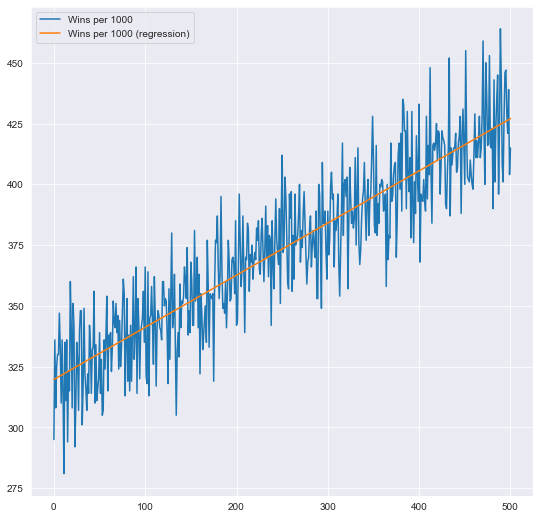

In [828]:
f, axes = plt.subplots(1, 1, figsize=(9, 9))

sns.set_style("darkgrid")
sns.lineplot(data=sumGames_sub,label=f'Wins per {countWindow}')
sns.lineplot(data=poly1d_fn(np.arange(len(sumGames_sub))), label=f"Wins per {countWindow} (regression)")

#plt.plot(sumGames)
#plt.plot(np.arange(len(sumGames)),poly1d_fn(np.arange(len(sumGames))),'--k')

Playing Set 0...
Playing Set 1...
Playing Set 2...
Playing Set 3...
Playing Set 4...
Playing Set 5...
Playing Set 6...
Playing Set 7...
Playing Set 8...


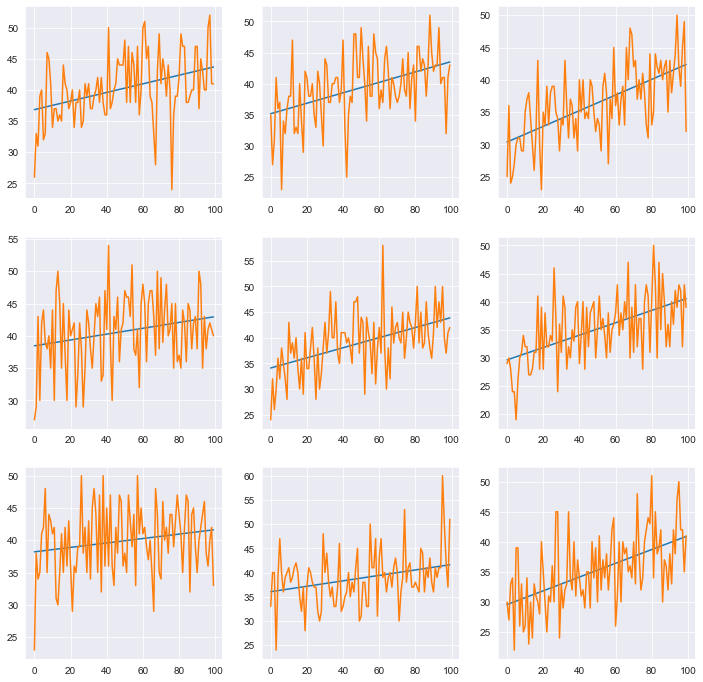

In [306]:
lr_l = [0.1, 0.3, 0.5]
exp_rate_l = [0.3,0.5,1]
combos = list(itertools.product(lr_l,exp_rate_l))
f, axes = plt.subplots(3, 3, figsize=(12, 12))

for index, combo in enumerate(combos):
    sol = BlackJackSolution(lr=combo[0],exp_rate=combo[1])
    print(f'Playing Set {index}...')
    sol.play(10000)
    
    countWindow = 100
    sumGames = np.add.reduceat(sol.gameTrack, np.arange(0, len(sol.gameTrack), countWindow))
    
    # Create regression 
    coef = np.polyfit(np.arange(len(sumGames)),sumGames,1)
    poly1d_fn = np.poly1d(coef)
    
    sns.lineplot(data=poly1d_fn(np.arange(len(sumGames))), ax=axes[math.floor(index/3),index % 3])
    sns.lineplot(data=sumGames,ax=axes[math.floor(index/3),index % 3])

In [307]:
sol.player_Q_Values

{(12, 1, True): {1: -0.193, 0: 0},
 (12, 1, False): {1: -0.303, 0: -0.867},
 (12, 2, True): {1: 0.694, 0: 0.875},
 (12, 2, False): {1: -0.598, 0: -0.961},
 (12, 3, True): {1: -0.149, 0: -0.5},
 (12, 3, False): {1: 0.044, 0: -0.951},
 (12, 4, True): {1: 0.253, 0: 0},
 (12, 4, False): {1: 0.387, 0: -0.918},
 (12, 5, True): {1: 0.438, 0: -0.688},
 (12, 5, False): {1: -0.933, 0: -0.916},
 (12, 6, True): {1: -0.685, 0: -0.75},
 (12, 6, False): {1: -0.932, 0: -0.405},
 (12, 7, True): {1: -0.458, 0: 0.344},
 (12, 7, False): {1: 0.252, 0: -0.591},
 (12, 8, True): {1: -0.135, 0: -0.5},
 (12, 8, False): {1: -0.637, 0: -0.98},
 (12, 9, True): {1: 0.142, 0: -0.75},
 (12, 9, False): {1: -0.844, 0: -0.989},
 (12, 10, True): {1: 0.008, 0: 0.91},
 (12, 10, False): {1: -0.459, 0: -0.997},
 (13, 1, True): {1: -0.44, 0: -0.812},
 (13, 1, False): {1: -0.677, 0: -0.871},
 (13, 2, True): {1: 0.348, 0: -0.375},
 (13, 2, False): {1: -0.506, 0: -0.975},
 (13, 3, True): {1: -0.523, 0: -0.391},
 (13, 3, False): 